In [21]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("juice0lover/users-vs-bots-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/users-vs-bots-classification



📋 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5874 entries, 0 to 5873
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   has_domain                  5874 non-null   object 
 1   has_birth_date              5874 non-null   object 
 2   has_photo                   5874 non-null   object 
 3   can_post_on_wall            5874 non-null   object 
 4   can_send_message            5874 non-null   object 
 5   has_website                 5874 non-null   object 
 6   gender                      5874 non-null   object 
 7   has_short_name              5874 non-null   object 
 8   has_first_name              5874 non-null   object 
 9   has_last_name               5874 non-null   object 
 10  access_to_closed_profile    5874 non-null   object 
 11  is_profile_closed           5874 non-null   object 
 12  target                      5874 non-null   int64  
 13  has_nickname      

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: Ru

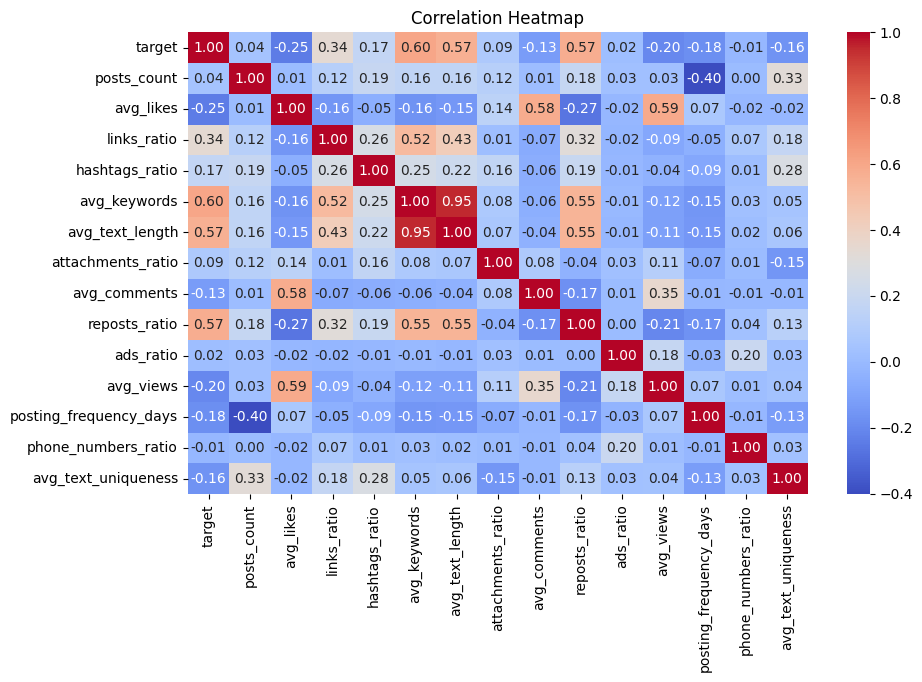

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ====== 1. Load Data ======
df = pd.read_csv('/kaggle/input/users-vs-bots-classification/bots_vs_users.csv')
df.head()

# ====== 2. Basic Info ======
print("\n📋 Basic Info:")
print(df.info())

# ====== 3. Missing Values Check ======
print("\n🔍 Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0])

# ====== 4. Skewness Check ======
print("\n📈 Skewness Check:")
skewed_features = df.select_dtypes(include=['number']).apply(lambda x: x.skew()).sort_values(ascending=False)
print(skewed_features)

print("\n📌 Recommendation:")
for col, skew in skewed_features.items():
    if abs(skew) > 1:
        print(f"⚠️ {col} is highly skewed (skew={skew:.2f}). Suggest: Apply log or sqrt transform.")
    elif abs(skew) > 0.5:
        print(f"ℹ️ {col} is moderately skewed (skew={skew:.2f}). Transform optional.")
    else:
        print(f"✅ {col} is fairly symmetric (skew={skew:.2f}). No action needed.")

# ====== 5. Outlier Detection (IQR Method) ======
print("\n📦 Outlier Check (IQR Method):")
for col in df.select_dtypes(include=['number']):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_count = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    if outlier_count > 0:
        print(f"⚠️ {col}: {outlier_count} outliers detected.")
    else:
        print(f"✅ {col}: No significant outliers.")

# ====== 6. Correlation Analysis ======
print("\n🔗 Correlation Matrix (Top correlated pairs):")
correlation = df.corr(numeric_only=True)
cor_matrix = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()
top_corr = cor_matrix[(cor_matrix < 1) & (cor_matrix > 0.7)]
print(top_corr)

print("\n📌 Recommendation:")
for (f1, f2), corr_val in top_corr.items():
    print(f"⚠️ {f1} & {f2} have high correlation ({corr_val:.2f}). Suggest: Keep only one or apply dimensionality reduction (e.g., PCA).")

# ====== 7. Heatmap ======
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [23]:
# Split data test & training
X = df.drop('target', axis=1)
y = df['target']

In [24]:
# Deteksi kolom kategorikal dan numerik
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

In [28]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Log transform untuk numerik yang skewed, biar distribusinya lebih normal.
log_transformer = FunctionTransformer(lambda x: np.log1p(x), validate=False) # log1p(x) artinya log(x + 1) → untuk menghindari log(0) error.

# Pipeline numerik
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Mengisi missing value dengan median (lebih tahan terhadap outlier).
    ('log', log_transformer)
]) # Kenapa digunakan ? Karena model seperti Random Forest atau Logistic Regression performa-nya bisa buruk kalau distribusi data sangat miring (skewed).

# Pipeline kategorikal
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), # Mengisi nilai kosong dengan 'Unknown' → supaya data tetap lengkap.
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # OneHotEncoder: Mengubah kategori jadi kolom biner (0/1) → diperlukan karena model tidak bisa membaca string
])

# Gabungkan preprocessor
preprocessor = ColumnTransformer([ # ColumnTransformer menggabungkan pipeline numerik dan kategorikal.
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Pipeline final
model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

In [26]:
# Tanpa Hyperparameter
# Train
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       588
           1       0.98      0.95      0.97       587

    accuracy                           0.97      1175
   macro avg       0.97      0.97      0.97      1175
weighted avg       0.97      0.97      0.97      1175



{'0': {'precision': 0.9505766062602965,
  'recall': 0.9812925170068028,
  'f1-score': 0.9656903765690377,
  'support': 588},
 '1': {'precision': 0.9806338028169014,
  'recall': 0.948892674616695,
  'f1-score': 0.9645021645021645,
  'support': 587},
 'accuracy': 0.9651063829787234,
 'macro avg': {'precision': 0.965605204538599,
  'recall': 0.9650925958117489,
  'f1-score': 0.9650962705356011,
  'support': 1175},
 'weighted avg': {'precision': 0.965592414242192,
  'recall': 0.9651063829787234,
  'f1-score': 0.9650967761577572,
  'support': 1175}}

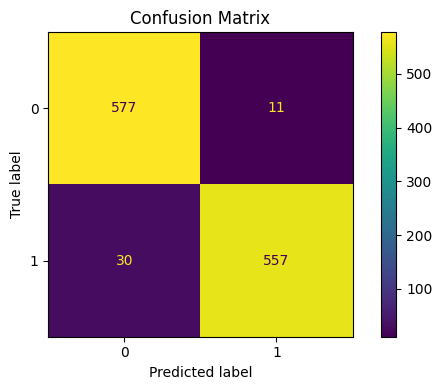

In [32]:
# Hyperparameter tuning dengan GridSearchCV
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20, None],
    'clf__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Prediksi dan Evaluasi
y_pred = grid_search.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)
best_model = grid_search.best_estimator_

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=grid_search.classes_)
disp.plot(ax=ax)
plt.title("Confusion Matrix")
plt.tight_layout()

grid_search.best_params_
report